# Przewidywanie ceny domków w Bostonie

## Wprowadzenie

Wykorzytsując popularny zbiór dot. domów w Bostonie stworzę model, który nauczy się przewidywać ich cenę.

Notebook powstał w ramach nauki modelowania regresji liniowej.

## Importowanie bibliotek

Będę korzystać z biblioteki:
* Pandas - do analizowania zbioru Boston House
* Matplotlib - do wizualizacji danych
* Seaborn - również do wizualizacji danych
* Scikit-learn - do pobrania setu oraz algorytmów ML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels.api as sm 
import warnings

Shape before deleting duplicate values: (506, 14)
Shape after deleting duplicate values: (506, 14)


## Pobieranie i przygotowanie zbioru danych
Zbiór na którym będę pracować jest dostępny w ramach Scikit-Learn

In [16]:
warnings.filterwarnings('ignore')

# Importing the Boston Housing dataset
from sklearn.datasets import load_boston
boston = load_boston()

boston_data = pd.DataFrame(boston.data)
boston_data.columns = boston.feature_names

#Adding target variable to dataframe
boston_data['PRICE'] = boston.target 
# Median value of owner-occupied homes in $1000s

Sprawdzę czy nie ma duplikatów w danych, gdyż modele osiągają lepsze wyniki ucząc się na danych, które się nie powtarzają.

In [17]:
#Check columns and rows 
print('Shape before deleting duplicate values:', boston_data.shape)
boston_data = boston_data.drop_duplicates()
print('Shape after deleting duplicate values:', boston_data.shape)

Shape before deleting duplicate values: (506, 14)
Shape after deleting duplicate values: (506, 14)


W secie nie było żadnych duplikatów, co jest bardzo dobrą informacją. Sprawdzę jak wygląda 5 pierwszy wierszy.

In [18]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Set posiada 14 kolumn z cechami domów w Bostonie. 
Poniżej opis każdej kolumny:

* CRIM - wskaźnik przestępczości na mieszkańca wg.] miast
* ZN - część gruntów mieszkalnych przeznaczonych na działki o pow. powyżej 25 000 stóp kwadratowych
* INDUS - odsetek akrów działalności niehandlowej na miasto
* CHAS  - fikcyjna zmienna Charles River (1 jest przeprawa przez rzekę, 0 nie ma przeprawy przez rzekę)
* NOX - stężenie tlenków azotu (część na 10 milionów)
* RM - średnia liczba pokoi na domek
* AGE - odsetek jednostek własnościowych wybudowanych przed 1940 
* DIS - ważone odległości do pięciu bostońskich centrów zatrudnienia
* RAD - wskaźnik dostępności do autostrad radialnych
* TAX - pełnowartościowa stawka podatku od nieruchomości za 10 000 USD
* PTRATIO - stosunek uczniów do nauczycieli wg miasta
* B 1000 - odsetek osób czarnoskórych wg miasta
* LSTAT - procentowy udział ludności o niższym statusie

**PRICE** to zmienna docelowa i jest nią średnia wartość domów zajmowanych przez właścicieli w 1 000 USD

Do algorytmu uczenia wybiorę tylko te cechy, które będą możliwie jak najbardziej skorelowane ze zmienną docelową.

Zmienne, które nie wpływają lub wpływają w bardzo małym stopniu na mój target będą od razu usuwane.

In [3]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 59.3 KB


In [4]:
boston_data.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
boston_data.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
PRICE      229
dtype: int64

W kolumnach 'CHAS' i 'RAD' jest mniej niż 20 unikalnych wartości co może oznaczać, że są to potencjalnie zmienne kategoryczne. Sprawdzę rozkład danych tych kolumn.

<AxesSubplot:xlabel='CHAS'>

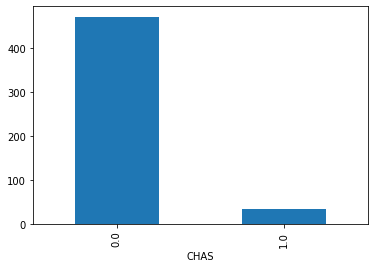

In [14]:
boston_data.groupby('CHAS').size().plot(kind='bar')


<AxesSubplot:xlabel='RAD'>

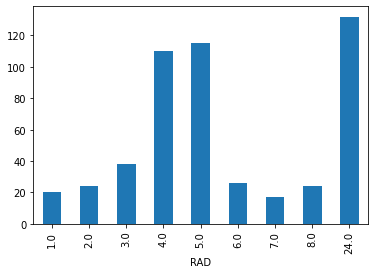

In [15]:
boston_data.groupby('RAD').size().plot(kind='bar')

Idealnie by było gdyby każda kategoria miała porównywalną ilość wystąpień. Zmienna 'RAD' ma dość porównywalne kategorie. Niestety zmienna 'CHAS' już nie. 

Na razie zostawie obie kolumny, ale będę je jeszcze testowała pod względem przydatności do modelu.

Sprawdzę jeszcze rozkład symetryczny zmiennej docelowej. Najlepiej to sobie zwizualizuje na histogramie.

<AxesSubplot:>

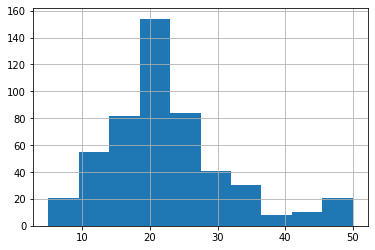

In [6]:
boston_data['PRICE'].hist()

Sprawdzę korelację wszystkich zmiennych ze zmieną docelową. Najlepiej to można zobaczyć na mapie cieplnej. 
Wyniki korelacji mieszą się w przedziale od -1 do 1. 
Wartości ujemne oznaczają słabą korelację.
Wartości dodatnie oznaczają silną korelację.
Analogicznie zero oznacza brak korelacji.

In [8]:
# Finding out the correlation between the features
corr = boston_data.corr()
corr.shape

(14, 14)

<AxesSubplot:>

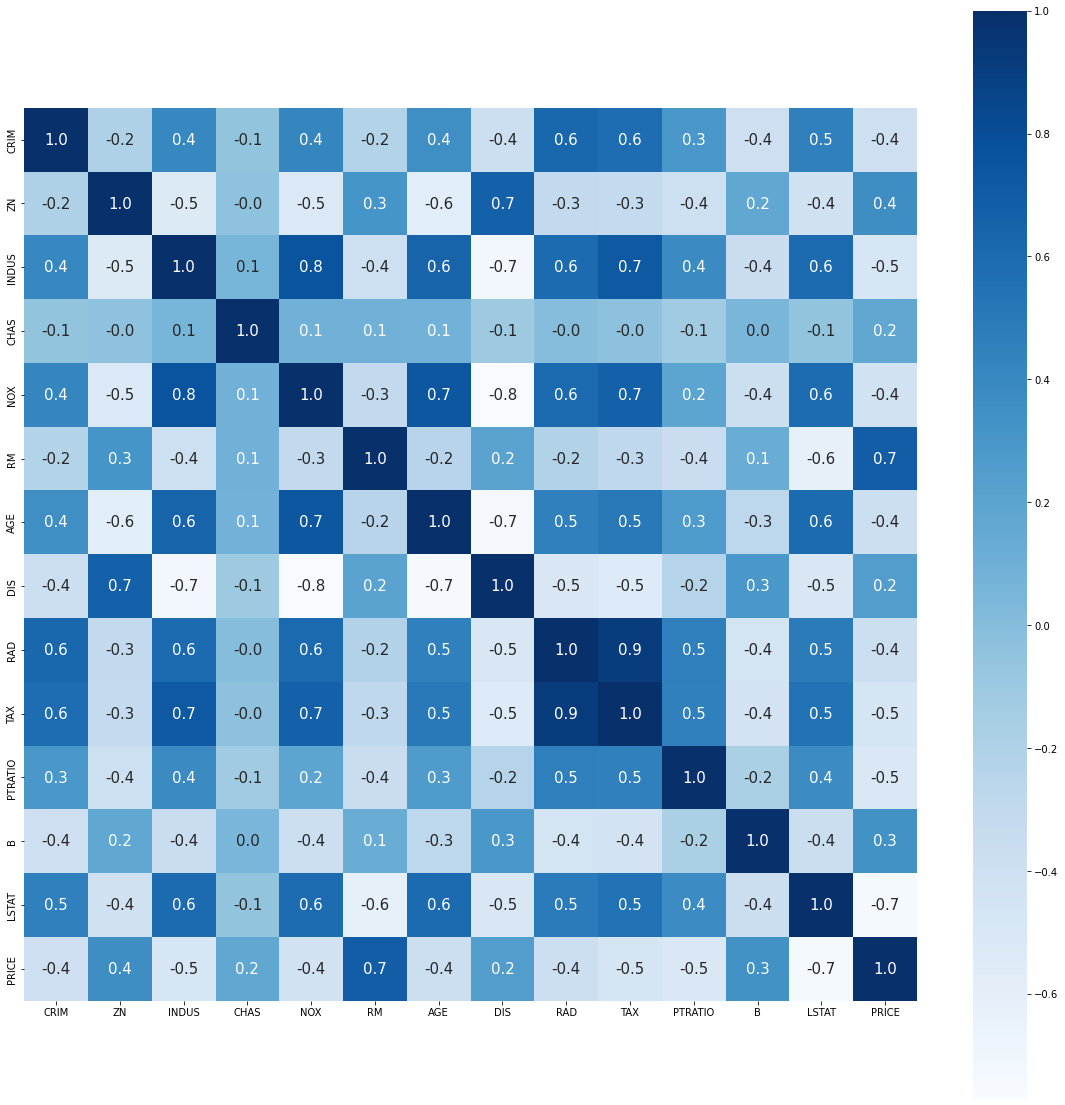

In [9]:
# Plotting the heatmap of correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Blues')

Patrząc na powyższą mapę korelacji mogę dokonać wstępnej selekcji cech do modelu.

* ~~CRIM~~ (-0.4) - słaba korelacja, do usunięcia
* ZN (0.4) - umiarkowana korelacja, zostaje
* ~~INDUS~~ (-0.5) - słaba korelacja, do usunięcia 
* CHAS (0.2) - mała korelacja, nieproporcjonalny rozkład, **do rozważenia**
* ~~NOX~~ (-0.4) - słaba korelacja, do usunięcia
* RM (0.7) - najlepiej skorelowana zmienna, zostaje
* ~~AGE~~ (-0.4) - słaba korelacja, do usunięcia
* DIS (0.2) - umiarkowana korelacja, zostaje
* RAD (-0.4) - słaba korelacja, ale jest to jedna z dwóch zmiennych kategorycznych w tym zbiorze, więc **do rozważenia** 
* ~~TAX~~ (-0.5) - słaba korelacja, do usunięcia
* ~~PTRATIO~~ (-0.5) - słaba korelacja, do usunięcia
* B 1000 (0.3) - umiarkowana korelacja, zostaje
* ~~LSTAT~~ (-0.7) - najgorsze korelacja, do usunięcia

Sprawdzę rozkład danych zmiennych, które zostają w modelu.
